In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch
import numpy as np
import matplotlib.pyplot as plt
import os, sys, shutil, copy, time, random

import sys
sys.path.append('../../')

In [5]:
from torchuq.metric.distribution import plot_cdf, plot_icdf, plot_density, plot_reliability_diagram
from torchuq.metric import distribution, quantile, interval
from torchuq.transform.naive import *
from torchuq.transform.conformal import *
from torchuq.transform.basic import *
from torchuq import _parse_name, _implicit_quantiles

torchuq.transform.basic


In [6]:
# Convert distribution to other representations
n_pred = 200
def generate_predictions(n_pred):
    pred_distribution = Normal(loc=torch.linspace(0, 2, n_pred)[torch.randperm(n_pred)], scale=torch.ones(n_pred))
    labels = pred_distribution.sample() 
    
    pred_point = distribution_to_point(pred_distribution, functional='mean') 
    pred_interval = distribution_to_interval(pred_distribution, confidence=0.9)
    pred_quantile = distribution_to_quantile(pred_distribution, n_quantiles=10)
    pred_quantile2 = distribution_to_quantile(pred_distribution, quantiles=torch.linspace(0, 1, 12)[1:-1].pow(3))   # Get a strange quantile choice to make sure things still work
    pred_particle = distribution_to_particle(pred_distribution, n_particles=30)
    pred_ensemble = {'point_1': pred_point, 'interval_1': pred_interval, 'quantile_1': pred_quantile} 

    prediction_list = [pred_particle, pred_distribution, pred_point, pred_interval, pred_quantile, pred_quantile2, pred_ensemble]
    prediction_type = ['particle', 'distribution', 'point', 'interval', 'quantile', 'quantile', 'ensemble']

    return prediction_list, prediction_type, labels

prediction_list, prediction_type, labels = generate_predictions(n_pred)

In [ ]:
def slice_prediction(predictions, t, ptype):
    if ptype == 'distribution':
        sliced = Normal(loc=predictions.loc[t:t+1], scale=predictions.scale[t:t+1])
    elif ptype == 'ensemble':
        sliced = {key: slice_prediction(val, t, _parse_name(key)[0]) for key, val in predictions.items()}
    else:
        sliced = predictions[t:t+1]
    return sliced

Test the calibration. The calibration should be perfect for random interpolation and 1/N for the other interpolations

Finished prediction particle test 0/100, time elapsed=0.2


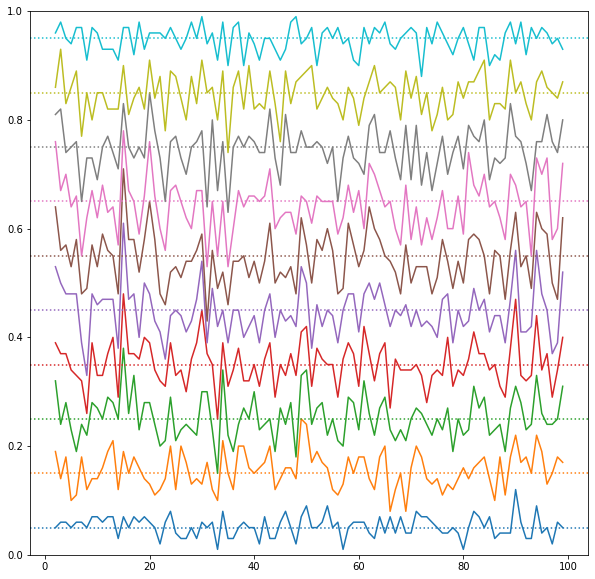

Finished prediction distribution test 0/100, time elapsed=18.9


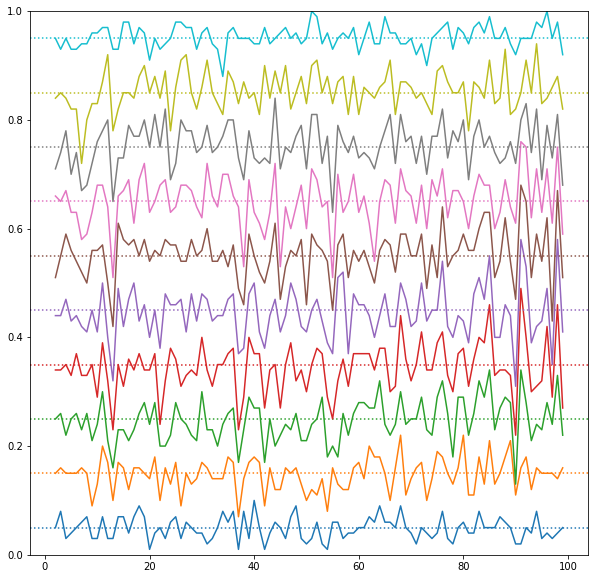

Finished prediction point test 0/100, time elapsed=90.4


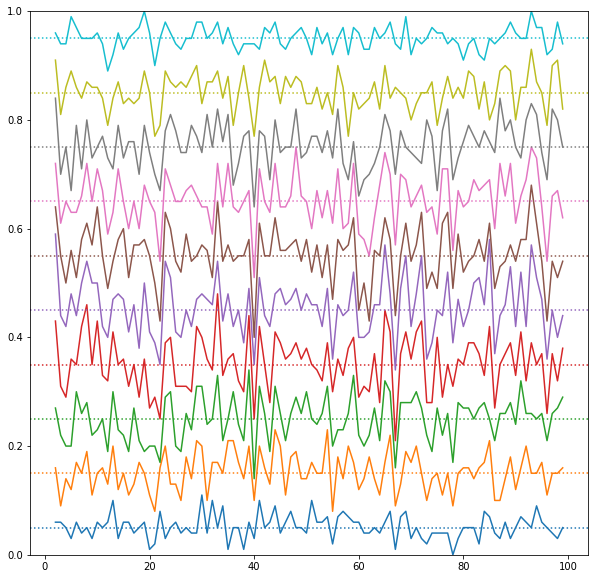

Finished prediction interval test 0/100, time elapsed=100.0


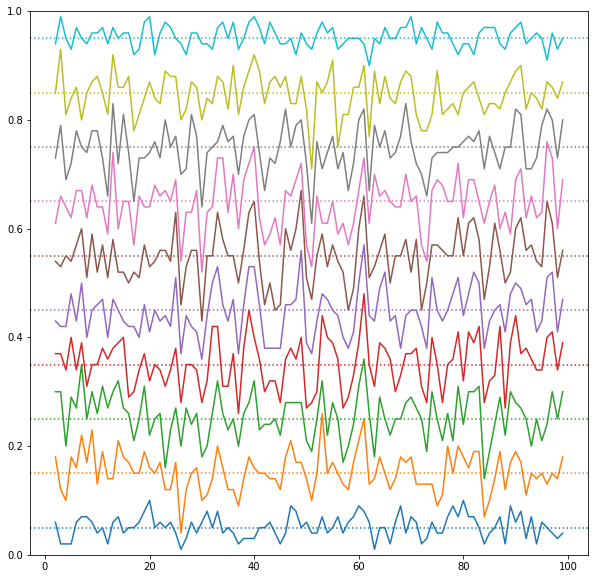

Finished prediction quantile test 0/100, time elapsed=112.7


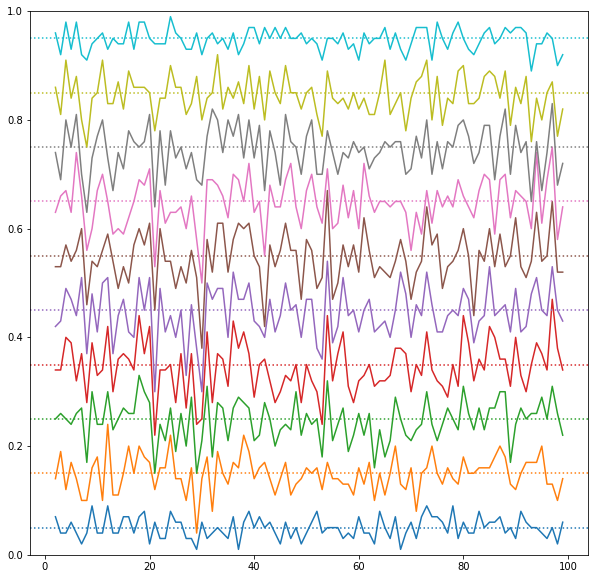

Finished prediction quantile test 0/100, time elapsed=132.3


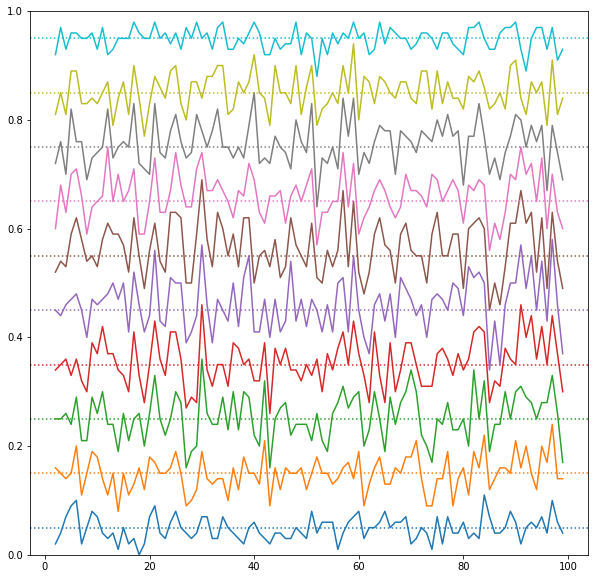

Finished prediction ensemble test 0/100, time elapsed=154.8


In [ ]:
# Check the correctness of empirical coverage 

total_test = 100
start_time = time.time()
for interpolation in ['linear', 'exact']:
    for pi, ptype in enumerate(prediction_type):
        coverage_list = []
        for repeat in range(total_test):
            calibrator = ConformalCalibrator(input_type=ptype, interpolation=interpolation)
            prediction_list, prediction_type, labels = generate_predictions(n_pred)
            prediction = prediction_list[pi]

            history = []
            max_t = 100
            for t in range(max_t): 
                sliced = slice_prediction(prediction, t, ptype)
                if t > 1:
                    pred_calibrated = calibrator(sliced)   
                    history.append(pred_calibrated)
                calibrator.update(sliced, labels[t:t+1])
            history = ConcatDistribution(history) 

            leq = (labels[2:max_t].view(-1, 1) <= distribution_to_quantile(history, n_quantiles=10)).type(torch.float32)
            coverage_list.append(leq)

            if repeat % 100 == 0:
                print("Finished prediction %s test %d/%d, time elapsed=%.1f" % (ptype, repeat, total_test, time.time() - start_time))
        # break
        coverage_list = torch.stack(coverage_list, axis=0).mean(dim=0).cpu()

        sample_index = np.array(range(2, max_t))
        quantiles = _implicit_quantiles(10)
        plt.figure(figsize=(10, 10))
        for i in range(10):
            plt.plot(sample_index, coverage_list[:, i], c='C%d' % i)
            plt.axhline(quantiles[i], c='C%d' % i, linestyle=':')

        plt.ylim([0, 1])
        plt.title('%s-%s' % (interpolation, ptype))
        plt.show()

In [ ]:
# Same as above but test coverage for linear
total_test = 1000
start_time = time.time()

for pi, ptype in enumerate(prediction_type):
    
    coverage_list = []
    for repeat in range(total_test):
        calibrator = ConformalCalibrator(input_type=ptype, interpolation='linear')
        prediction_list, prediction_type, labels = generate_predictions(n_pred)
        prediction = prediction_list[pi]
        
        history = []
        max_t = 100
        for t in range(max_t): 
            sliced = slice_prediction(prediction, t, ptype)
            if t > 1:
                pred_calibrated = calibrator(sliced)   
                history.append(pred_calibrated)
            calibrator.update(sliced, labels[t:t+1])
        history = ConcatDistribution(history) 
        
        leq = (labels[2:max_t].view(-1, 1) <= distribution_to_quantile(history, n_quantiles=10)).type(torch.float32)
        coverage_list.append(leq)
    
        if repeat % 100 == 0:
            print("Finished prediction %s test %d/%d, time elapsed=%.1f" % (ptype, repeat, total_test, time.time() - start_time))
    # break
    coverage_list = torch.stack(coverage_list, axis=0).mean(dim=0).cpu()

    sample_index = np.array(range(2, max_t))
    quantiles = _implicit_quantiles(10)
    plt.figure(figsize=(10, 10))
    for i in range(10):
        plt.plot(sample_index, coverage_list[:, i], c='C%d' % i)
        plt.axhline(quantiles[i], c='C%d' % i, linestyle=':')
        
        plt.plot(sample_index, quantiles[i] - 1 / sample_index, c='C%d' % i, linestyle=':')
        plt.plot(sample_index, quantiles[i] + 1 / sample_index, c='C%d' % i, linestyle=':')
    plt.show()

Finished prediction particle test 0/100, time elapsed=0.2


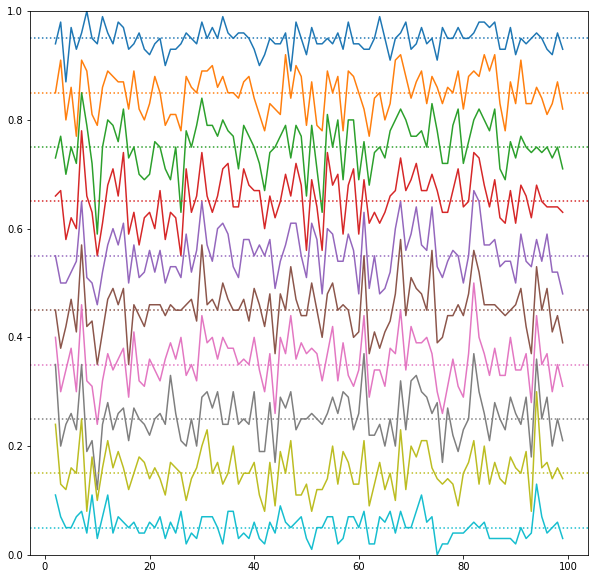

Finished prediction distribution test 0/100, time elapsed=19.2


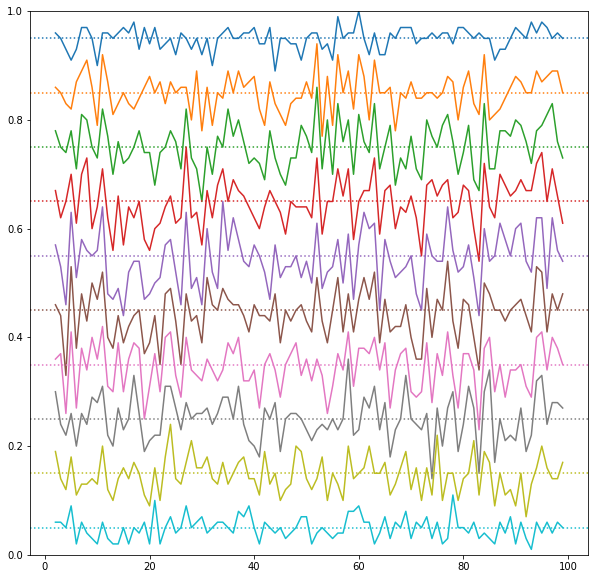

Finished prediction point test 0/100, time elapsed=91.2


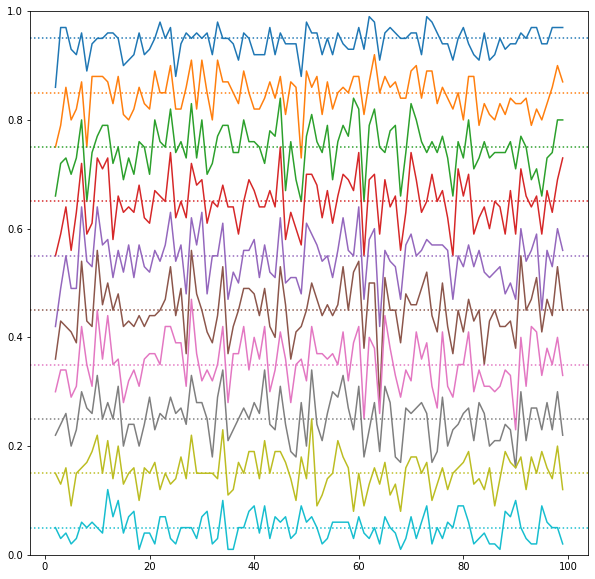

Finished prediction interval test 0/100, time elapsed=100.9


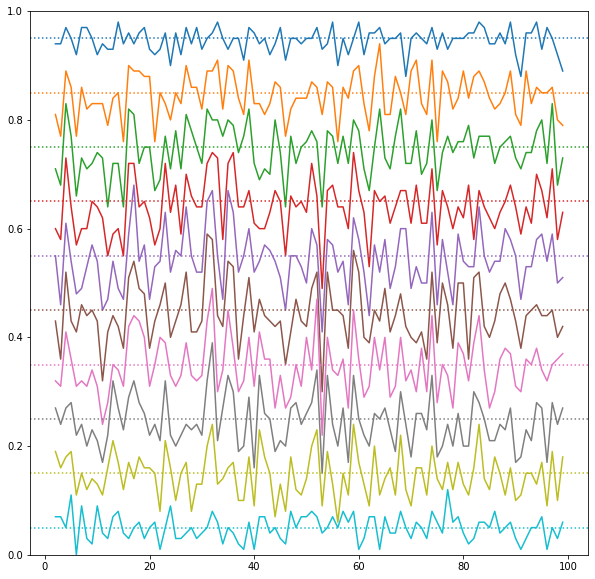

Finished prediction quantile test 0/100, time elapsed=113.5


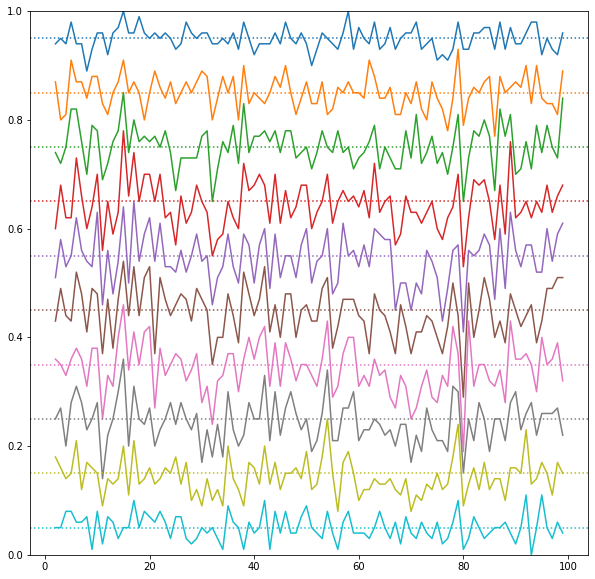

Finished prediction quantile test 0/100, time elapsed=133.4


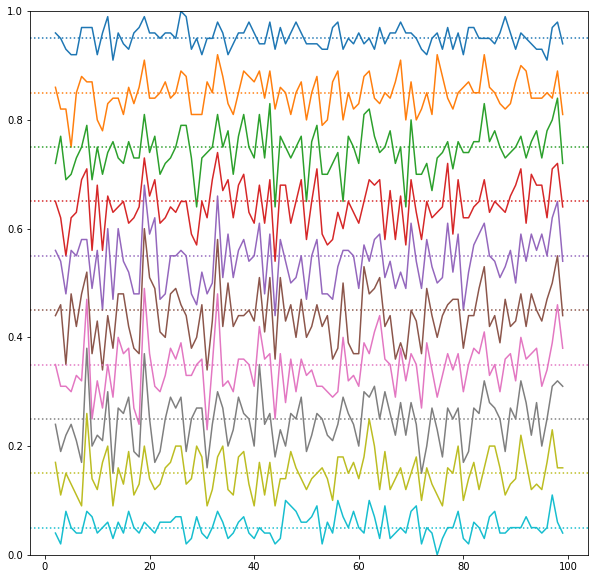

Finished prediction ensemble test 0/100, time elapsed=156.3


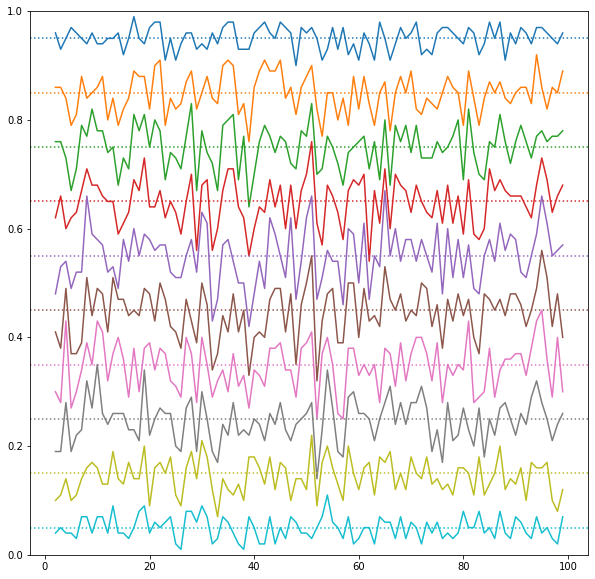

In [9]:
# Check the correctness of empirical coverage 

total_test = 100
start_time = time.time()
for pi, ptype in enumerate(prediction_type):
    coverage_list = []
    for repeat in range(total_test):
        calibrator = ConformalCalibrator(input_type=ptype, interpolation='random')
        prediction_list, prediction_type, labels = generate_predictions(n_pred)
        prediction = prediction_list[pi]
        
        history = []
        max_t = 100
        for t in range(max_t): 
            sliced = slice_prediction(prediction, t, ptype)
            if t > 1:
                pred_calibrated = calibrator(sliced)   
                history.append(pred_calibrated)
            calibrator.update(sliced, labels[t:t+1])
        history = ConcatDistribution(history) 
        
        pred_quantile = distribution_to_quantile(history, n_quantiles=20)
        coverage = (labels[2:max_t].view(-1, 1) >= pred_quantile[:, :10]) & (labels[2:max_t].view(-1, 1) <= pred_quantile[:, 10:].flip(dims=[1]))
        coverage_list.append(coverage.type(torch.float32))
    
        if repeat % 100 == 0:
            print("Finished prediction %s test %d/%d, time elapsed=%.1f" % (ptype, repeat, total_test, time.time() - start_time))
    # break
    coverage_list = torch.stack(coverage_list, axis=0).mean(dim=0).cpu()

    sample_index = np.array(range(2, max_t))
    quantiles = [0.95, 0.85, 0.75, 0.65, 0.55, 0.45, 0.35, 0.25, 0.15, 0.05]
    plt.figure(figsize=(10, 10))
    for i in range(10):
        plt.plot(sample_index, coverage_list[:, i], c='C%d' % i)
        plt.axhline(quantiles[i], c='C%d' % i, linestyle=':')
        
    plt.ylim([0, 1])
    plt.show()